# Определение стоимости автомобилей

**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Данные находятся в файле [`/datasets/autos.csv`](https://code.s3.yandex.net/datasets/autos.csv). 

**Признаки**

+ `DateCrawled` — дата скачивания анкеты из базы
+ `VehicleType` — тип автомобильного кузова
+ `RegistrationYear` — год регистрации автомобиля
+ `Gearbox` — тип коробки передач
+ `Power` — мощность (л. с.)
+ `Model` — модель автомобиля
+ `Kilometer` — пробег (км)
+ `RegistrationMonth` — месяц регистрации автомобиля
+ `FuelType` — тип топлива
+ `Brand` — марка автомобиля
+ `Repaired` — была машина в ремонте или нет
+ `DateCreated` — дата создания анкеты
+ `NumberOfPictures` — количество фотографий автомобиля
+ `PostalCode` — почтовый индекс владельца анкеты (пользователя)
+ `LastSeen` — дата последней активности пользователя

**Целевой признак**
+ `Price` — цена (евро)

**План работы**

1. Подготовка данных
    + Импорт библиотек
    + Загрузка данных из файла: /datasets/autos.csv.
    + Предобработка данных. 
        + Удаление неинформативных признаков
        + Заполненение пропущенных значений
        + Обработка аномалий в столбцах    
2. Подготовка выборки для обучения моделей
3. Обучение разных модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели подберём разные гиперпараметры
4. Анализ времени обучения, времени предсказания и качество моделей
5. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке

## Подготовка данных

### Установка пакетов

In [1]:
!pip install -U scikit-learn -q

### Импорт библиотек

In [2]:
import lightgbm as lgb
import numpy as np
import pandas  as pd
pd.DataFrame.iteritems = pd.DataFrame.items
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import re
import seaborn as sns
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     RandomizedSearchCV
                                    )
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   StandardScaler
                                  )

try:
    import phik
except:
    !pip install phik -q
    import phik
    
try:
    from category_encoders import BinaryEncoder
except:
    !pip install category_encoders -q
    from category_encoders import BinaryEncoder

### Загрузка данных

In [3]:
autos = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Данные загружены, можно переходить к предобработке.

### Предобработка данных

При работе с наборами данных важно привести наименования колонок к единому формату: все буквы должны быть строчными, а вместо пробелов следует использовать символы подчёркивания для улучшения читаемости и стандартизации

In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [5]:
autos = autos.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower()) 
autos

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


**Удалим неинформативные признаки (не влияющие на стоимость автомобиля)**

+ `DateCrawled` — дата скачивания анкеты из базы
+ `RegistrationMonth` — месяц регистрации автомобиля
+ `DateCreated` — дата создания анкеты
+ `NumberOfPictures` — количество фотографий автомобиля
+ `PostalCode` — почтовый индекс владельца анкеты (пользователя)
+ `LastSeen` — дата последней активности пользователя

In [6]:
autos = autos.drop(['date_crawled', 'registration_month', 'date_created', 
                  'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


#### Удаление явных дубликатов

In [7]:
autos.duplicated().sum()

45040

In [8]:
autos = autos.drop_duplicates()
autos.info(), autos.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              309329 non-null  int64 
 1   vehicle_type       274770 non-null  object
 2   registration_year  309329 non-null  int64 
 3   gearbox            292122 non-null  object
 4   power              309329 non-null  int64 
 5   model              290968 non-null  object
 6   kilometer          309329 non-null  int64 
 7   fuel_type          278565 non-null  object
 8   brand              309329 non-null  object
 9   repaired           244771 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


(None,
 price                    0
 vehicle_type         34559
 registration_year        0
 gearbox              17207
 power                    0
 model                18361
 kilometer                0
 fuel_type            30764
 brand                    0
 repaired             64558
 dtype: int64)

#### Заполнение пропущенных значений после проверки на уникальность

In [9]:
print(sorted(autos['vehicle_type'].dropna().unique()))

['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']


In [10]:
print(sorted(autos['gearbox'].dropna().unique()))

['auto', 'manual']


In [11]:
print(sorted(autos['model'].dropna().unique()))

['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 'fortwo', 'fox', 'freelander', 'fusion', 

In [12]:
autos['fuel_type'] = autos['fuel_type'].replace('gasoline','petrol')
print(sorted(autos['fuel_type'].dropna().unique()))

['cng', 'electric', 'hybrid', 'lpg', 'other', 'petrol']


In [13]:
print(sorted(autos['repaired'].dropna().unique()))

['no', 'yes']


In [14]:
print(sorted(autos['brand'].dropna().unique()))

['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']


В ходе предварительной проверки набора данных было установлено отсутствие орфографических ошибок и дубликатов в наименованиях категорий.

Для корректной обработки отсутствующих значений в категориальных переменных предлагается следующая методология:
+ Технические характеристики транспортного средства:
    + В колонках, описывающих тип транспортного средства (`vehicle_type`), модель (`model`) и тип используемого топлива (`fuel_type`), все пустые записи будут заменены на значение unknown.
+ Параметры трансмиссии:
    + В колонке `gearbox`, содержащей информацию о типе коробки передач, возможны три варианта значений:
        + `auto` — автоматическая трансмиссия
        + `manual` — механическая трансмиссия
        + `unknown` — отсутствие данных о типе трансмиссии (включая случаи продажи автомобиля без коробки передач)
+ Состояние ремонта:
    + В колонке `repaired`, отражающей историю ремонтных работ, предусмотрены следующие значения:
        + `no` — автомобиль не был в ремонте
        + `yes` — автомобиль проходил ремонтные работы
        + `unknown` — транспортное средство находится в состоянии, требующем ремонта, но ремонтные работы не были выполнены

Такой подход к обработке пропусков позволит сохранить целостность данных и обеспечить корректность последующего анализа.

In [15]:
autos['vehicle_type'] = autos['vehicle_type'].fillna('unknown')
autos['model'] = autos['model'].fillna('unknown')
autos['fuel_type'] = autos['fuel_type'].fillna('unknown')
autos['gearbox'] = autos['gearbox'].fillna('unknown')
autos['repaired'] = autos['repaired'].fillna('unknown')

In [16]:
print(f'Мощность "brand" {len(autos.brand.unique())}')
print(f'Мощность "model" {len(autos.model.unique())}')
print(f'Мощность "vehicle_type" {len(autos.vehicle_type.unique())}')

Мощность "brand" 40
Мощность "model" 251
Мощность "vehicle_type" 9


In [17]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              309329 non-null  int64 
 1   vehicle_type       309329 non-null  object
 2   registration_year  309329 non-null  int64 
 3   gearbox            309329 non-null  object
 4   power              309329 non-null  int64 
 5   model              309329 non-null  object
 6   kilometer          309329 non-null  int64 
 7   fuel_type          309329 non-null  object
 8   brand              309329 non-null  object
 9   repaired           309329 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


In [18]:
autos.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

#### Подготовка и очистка данных
**Стандартизация структуры данных**
В рамках предварительной обработки информации были реализованы следующие преобразования:
+ Унификация наименований: все названия столбцов были трансформированы в формат нижнего регистра с разделением составных элементов посредством символов подчёркивания.
+ Исключение избыточных параметров: произведена фильтрация и удаление характеристик, не несущих значимой информационной нагрузки:
    + Временные параметры:
        + `DateCrawled` — метка времени извлечения данных из исходной базы
        + `DateCreated` — момент формирования анкеты
        + `LastSeen` — дата последнего взаимодействия пользователя с системой
    + Регистрационная информация:
        + `RegistrationMonth` — месяц постановки транспортного средства на учёт
    + Вспомогательные метрики:
        + `NumberOfPictures` — число загруженных изображений транспортного средства
        + `PostalCode` — почтовый индекс пользователя, разместившего объявление

**Оптимизация набора данных**
+ Дедупликация: идентифицировано и удалено 45 040 записей, являющихся полными дубликатами, что позволило повысить качество анализируемой выборки.

**Работа с пропущенными значениями**
Для обеспечения целостности информационной базы были реализованы следующие процедуры:
+ Обработка категориальных признаков:
    + В колонках, содержащих информацию о типе транспортного средства (`vehicle_type`), его модели (`model`) и типе используемого топлива (`fuel_type`), все отсутствующие значения были заменены на специальное значение unknown.
+ Модификация параметров трансмиссии:
    + В колонке `gearbox`, отражающей тип коробки передач, реализованы следующие варианты:
        + `auto` — автоматическая трансмиссия
        + `manual` — механическая трансмиссия
        + `unknown` — отсутствие данных о типе трансмиссии (включая случаи продажи автомобиля без коробки передач)
+ Классификация состояния ремонта:
    + В колонке `repaired`, характеризующей историю ремонтных работ, предусмотрены следующие значения:
        + `no` — отсутствие ремонтных работ
        + `yes` — наличие выполненных ремонтных работ
        + `unknown` — состояние, требующее ремонта без подтверждения его выполнения

Данные преобразования обеспечили формирование структурированного и качественного набора данных, готового к дальнейшему анализу и моделированию.

### 1.5. Исследовательский анализ данных

In [19]:
autos.describe()

,price,registration_year,power,kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


#### Анализ `price` - цена (евро)

Стоимость транспортного средства не может равняться нулевой отметке, что указывает на возможные пропуски ценовых данных при формировании исходного набора информации. Такие записи будут исключены из анализируемого массива. При этом значения, превышающие полуторное межквартильное расстояние, сохраняем без изменений.

In [20]:
def f_hist_box_1(hb1, bins, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,5), gridspec_kw={"height_ratios": (.15, .85)})
     
    sns.boxplot(data=[hb1], orient="h", ax=ax_box)
    plt.hist([hb1], 
             bins=bins, range=(hb1.min(), hb1.max()), label=hb1.name)
 
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

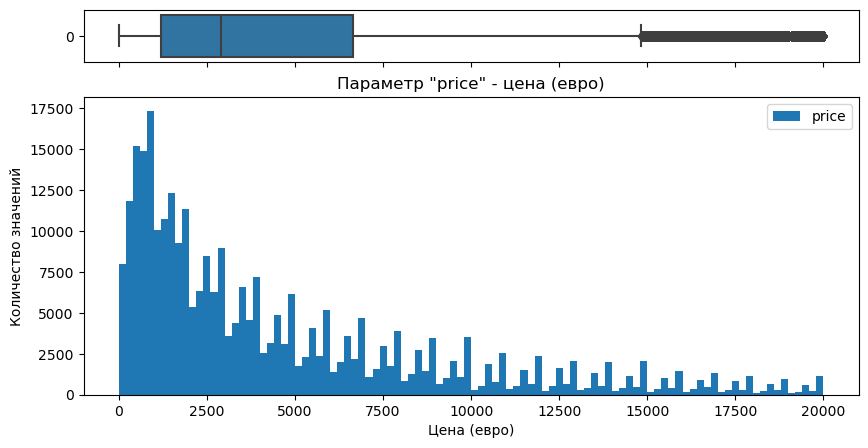

In [21]:
autos = autos[autos['price'] != 0]
f_hist_box_1(
    hb1=autos['price'],
    bins=100,   
    title='Параметр "price" - цена (евро)',
    xlabel='Цена (евро)',
    ylabel='Количество значений'
)

#### Анализ `registration_year` - год регистрации автомобиля

Год постановки транспортного средства на учёт не должен превышать текущий временной период. Учитывая специфику онлайн-площадок по продаже автомобилей, маловероятно присутствие на них предложений от коллекционеров раритетной автотехники. Кроме того, принимая во внимание значительную стоимость старинных автомобилей, было принято решение установить нижнюю границу года выпуска на уровне 1960 года — именно такие транспортные средства всё ещё активно эксплуатируются на дорогах общего пользования.

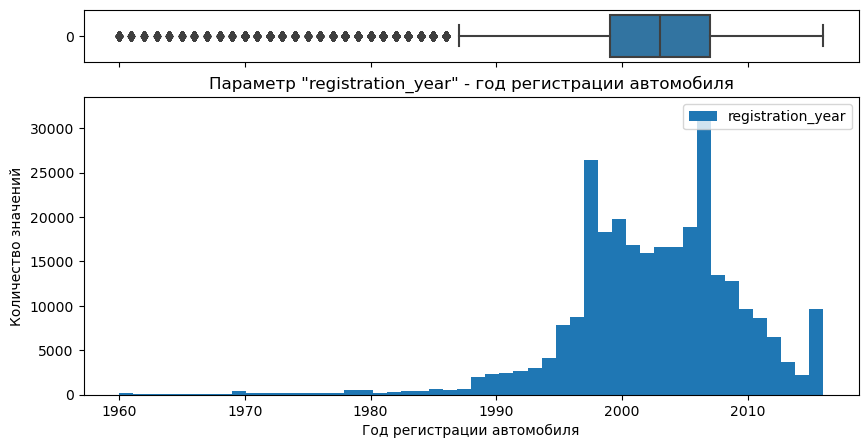

In [22]:
autos = autos[(autos['registration_year'] >= 1960) & (autos['registration_year'] <= 2016)]
f_hist_box_1(
    hb1=autos['registration_year'],
    bins=50,   
    title='Параметр "registration_year" - год регистрации автомобиля',
    xlabel='Год регистрации автомобиля',
    ylabel='Количество значений'
)

#### Анализ `kilometer` - пробег (км)

Здесь значения выглядят правдоподобно, оставим как есть.

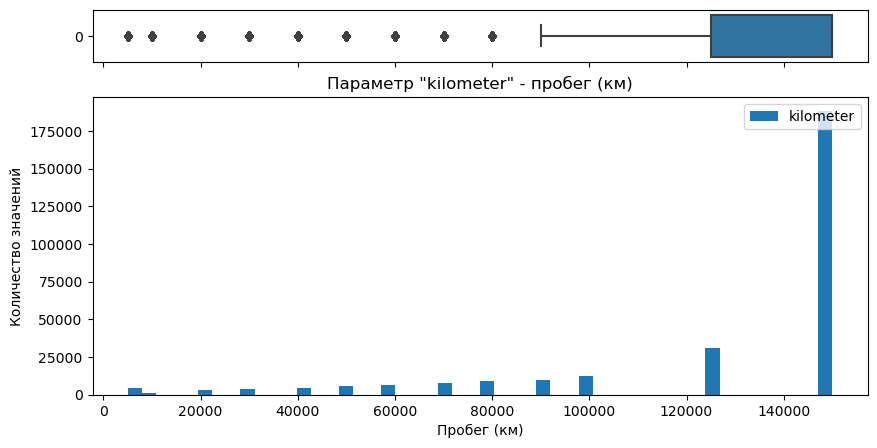

In [23]:
f_hist_box_1(
    hb1=autos['kilometer'],
    bins=50,   
    title='Параметр "kilometer" - пробег (км)',
    xlabel='Пробег (км)',
    ylabel='Количество значений'
)

#### Анализ `power` - мощность (л. с.)

Показатели мощности современных транспортных средств редко достигают отметки в 500 лошадиных сил. В связи с этим будет произведена корректировка соответствующих значений в наборе данных. При этом нулевые показатели мощности решено сохранить, поскольку существуют случаи продажи транспортных средств без силового агрегата, к тому же такие записи встречаются в массиве данных достаточно часто.

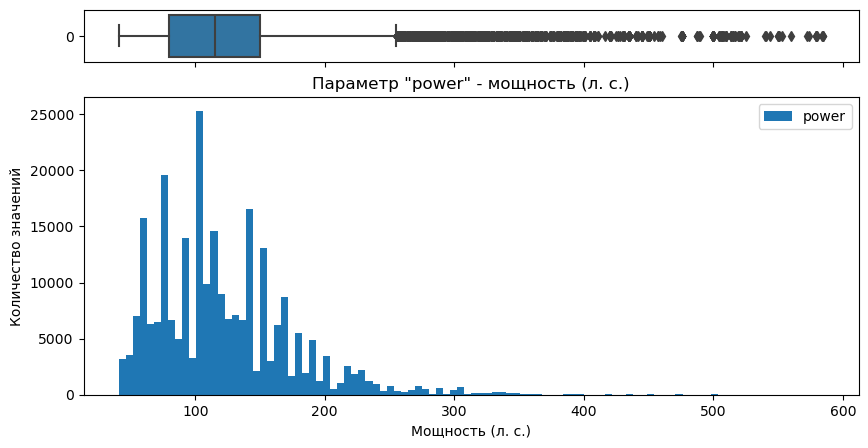

In [24]:
autos = autos[(autos['power'] > 40) & (autos['power'] < 600)]
f_hist_box_1(
    hb1=autos['power'],
    bins=100,   
    title='Параметр "power" - мощность (л. с.)',
    xlabel='Мощность (л. с.)',
    ylabel='Количество значений'
)

In [25]:
autos.describe(include='object')

,vehicle_type,gearbox,model,fuel_type,brand,repaired
count,255835,255835,255835,255835,255835,255835
unique,9,3,250,7,40,3
top,sedan,manual,golf,petrol,volkswagen,no
freq,70770,198581,19879,235919,52664,190038


+ В данных обнаружено большое количество выбросов.
+ Исключены строки по параметру `price - цена (евро) с нулевым значением.
+ Исключены строки по параметру `registration_year` - год регистрации автомобиля ранее 1960 года и более текущего года
+ Исключены строки по параметру `power` - мощность (л. с.) со значением 0 л.с. и более 500 л.с.

### Корреляционный анализ данных

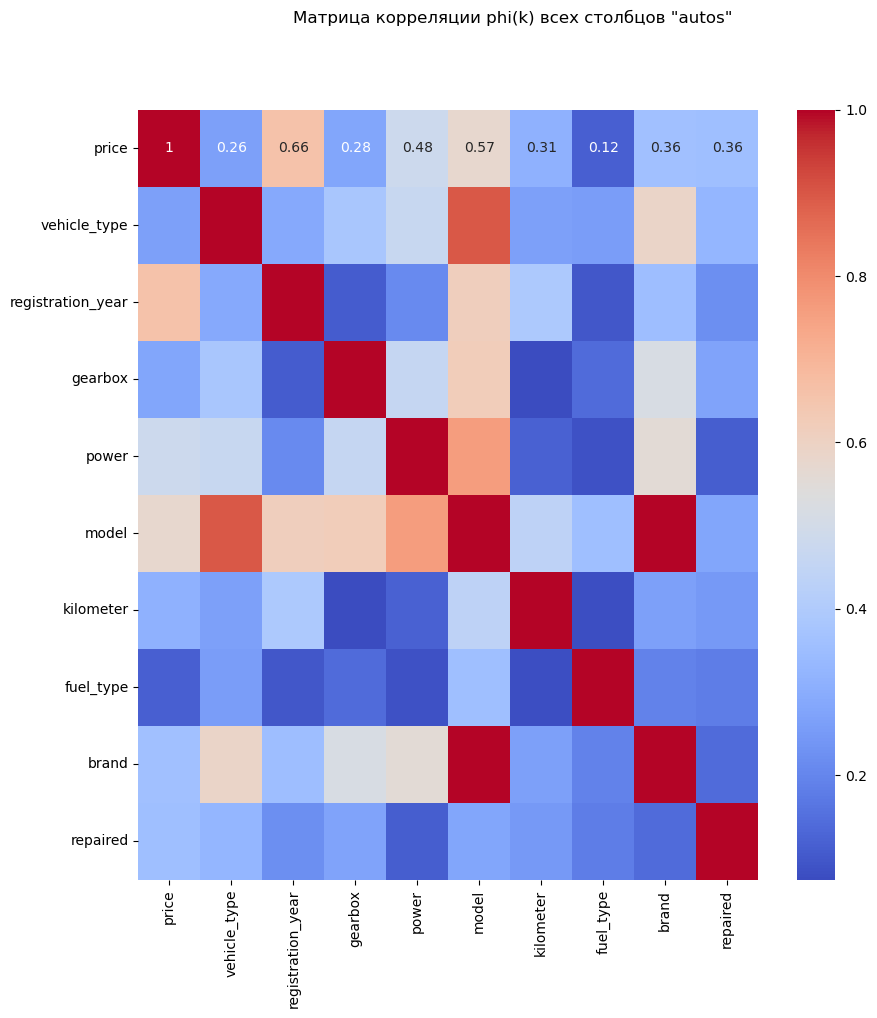

In [26]:
interval_cols = ['price',
                 'registration_year',
                 'power',
                 'kilometer'
                ]
fig, ax = plt.subplots(figsize=(10, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "autos"')
sns.heatmap(autos.phik_matrix(interval_cols = interval_cols), annot=True, cmap='coolwarm');

Выявлена существенная корреляционная связь между стоимостью транспортного средства (`price`) и следующими параметрами:

+ Год регистрации (`registration_year`) — коэффициент корреляции составляет 0.66
+ Модель автомобиля (`model`) — коэффициент корреляции равен 0.57

При этом влияние остальных параметров на ценообразование является несущественным.

Обнаружена абсолютная взаимосвязь между маркой транспортного средства (`brand`) и его моделью (`model`), коэффициент корреляции достигает максимального значения 1. Для предотвращения проблемы мультиколлинеарности в модели принято решение объединить эти характеристики в единый признак.

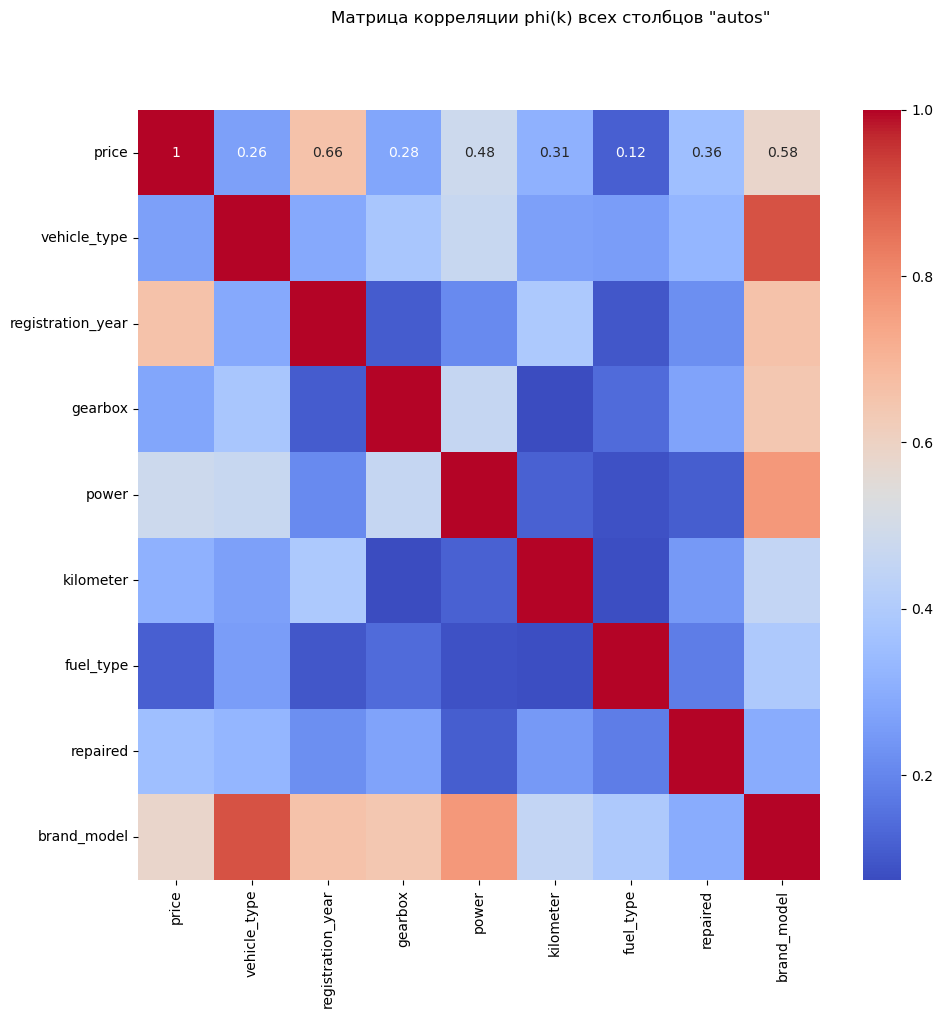

In [27]:
autos['brand_model'] = autos['brand'] + '_' + autos['model']
autos = autos.drop(columns=['brand', 'model'])
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "autos"')
sns.heatmap(autos.phik_matrix(interval_cols = interval_cols), annot=True, cmap='coolwarm');

Прослеживается прямая зависимость между брендом_моделью `brand_model` и типом кузова `vehicle_type` автомобиля `model` phi(k) = 0.9 для устранения мультиколлениарности объеденим стобец в один.

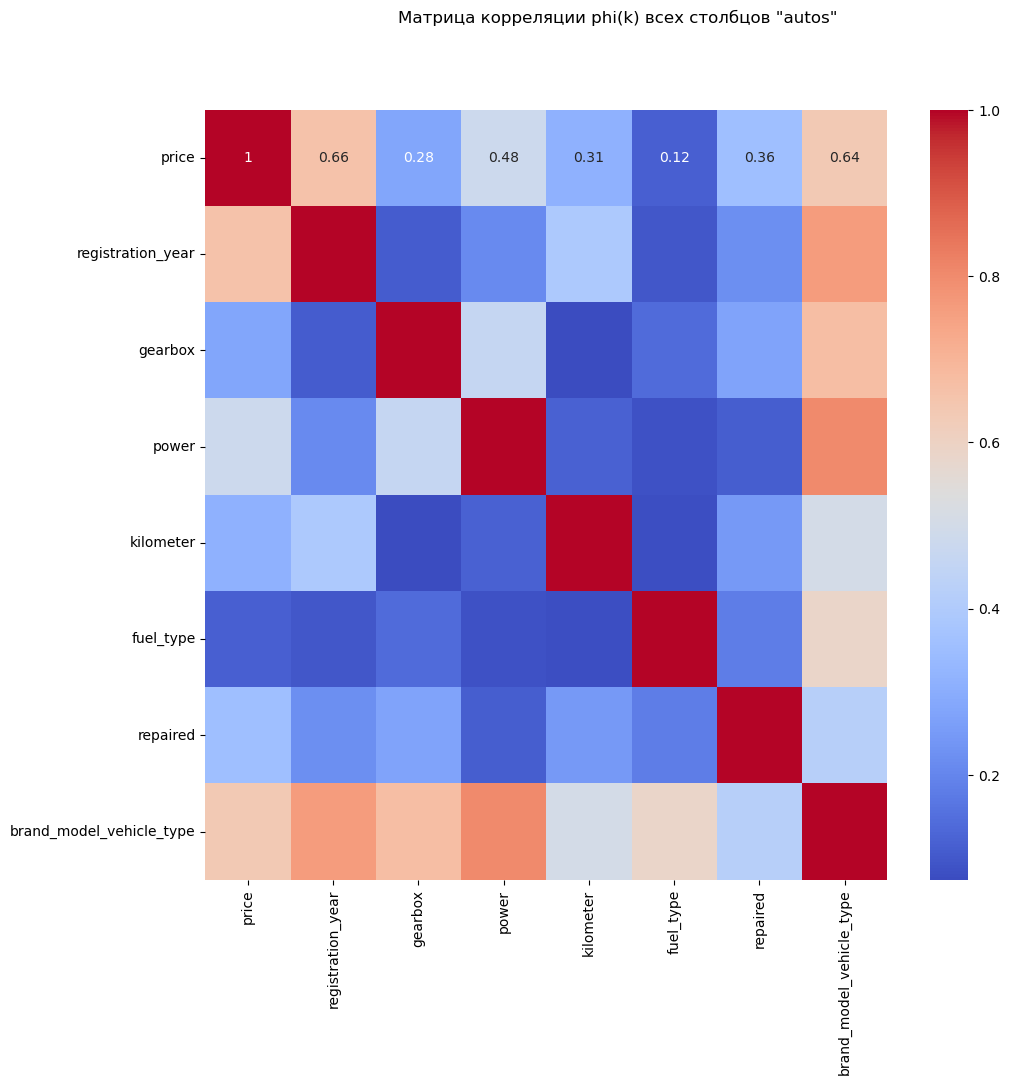

In [28]:
autos['brand_model_vehicle_type'] = autos['brand_model'] + '_' + autos['vehicle_type']
autos = autos.drop(columns=['brand_model', 'vehicle_type'])
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "autos"')
sns.heatmap(autos.phik_matrix(interval_cols = interval_cols), annot=True, cmap='coolwarm');

**Вывод по подготовке данных**

**Этапы обработки и анализа данных**
1. Первичная загрузка и предобработка
На начальном этапе были выполнены следующие операции:
+ Импортирование данных в рабочую среду
+ Стандартизация структуры:
    + Реновация наименований столбцов
    + Элиминация нерелевантных атрибутов:
        + `DateCrawled` — время извлечения данных
        + `RegistrationMonth` — месяц регистрации ТС
        + `DateCreated` — дата создания записи
        + `NumberOfPictures` — количество изображений
        + `PostalCode` — почтовый индекс владельца
        + `LastSeen` — последняя активность пользователя
+ Очистка данных:
    + Удаление дублирующихся записей
    + Импутация пропущенных значений

2. Исследовательский анализ
В ходе детального изучения набора данных выявлены следующие особенности:
+ Аномальные значения:
    + Обнаружено значительное количество экстремальных показателей
    + Фильтрация записей с нулевыми значениями стоимости
    + Отсеивание некорректных данных по году регистрации (до 1960 и после текущего года)
    + Исключение значений мощности свыше 500 лошадиных сил

3. Корреляционный анализ
Результаты исследования взаимосвязей между параметрами:
+ Синергия признаков:
    + Выявлена сильная корреляция между характеристиками транспортного средства
    + Для минимизации мультиколлинеарности осуществлено объединение полей:
        + `brand`
        + `model`
        + `vehicle_type`
    + Создан комплексный атрибут `brand_model_vehicle_type`
+ Влияние на целевую переменную:
    + Коэффициент корреляции с ценой (phi(k)) составляет 0.64
    + Существенное воздействие демонстрирует параметр года регистрации
    + Остальные характеристики оказывают незначительное влияние на итоговую стоимость

Данная последовательность преобразований позволила сформировать качественный датасет для последующего моделирования и анализа.

## Обучение моделей

In [29]:
autos.head(10)

,price,registration_year,gearbox,power,kilometer,fuel_type,repaired,brand_model_vehicle_type
1,18300,2011,manual,190,125000,petrol,yes,audi_unknown_coupe
2,9800,2004,auto,163,125000,petrol,unknown,jeep_grand_suv
3,1500,2001,manual,75,150000,petrol,no,volkswagen_golf_small
4,3600,2008,manual,69,90000,petrol,no,skoda_fabia_small
5,650,1995,manual,102,150000,petrol,yes,bmw_3er_sedan


### Подготовка выборки для обучения моделей

In [30]:
cat_col_names = ['gearbox', 'fuel_type', 'repaired', 'brand_model_vehicle_type']

num_col_names = ['registration_year', 'power', 'kilometer']
autos[cat_col_names] = autos[cat_col_names].astype('category')
autos.info()

autos.reset_index(drop= True, inplace= True)

RANDOM_STATE = 42
X = autos.drop(columns='price')
y = autos['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
Index: 255835 entries, 1 to 354368
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   price                     255835 non-null  int64   
 1   registration_year         255835 non-null  int64   
 2   gearbox                   255835 non-null  category
 3   power                     255835 non-null  int64   
 4   kilometer                 255835 non-null  int64   
 5   fuel_type                 255835 non-null  category
 6   repaired                  255835 non-null  category
 7   brand_model_vehicle_type  255835 non-null  category
dtypes: category(4), int64(4)
memory usage: 11.1 MB


In [31]:
autos.head(10)

,price,registration_year,gearbox,power,kilometer,fuel_type,repaired,brand_model_vehicle_type
0,18300,2011,manual,190,125000,petrol,yes,audi_unknown_coupe
1,9800,2004,auto,163,125000,petrol,unknown,jeep_grand_suv
2,1500,2001,manual,75,150000,petrol,no,volkswagen_golf_small
3,3600,2008,manual,69,90000,petrol,no,skoda_fabia_small
4,650,1995,manual,102,150000,petrol,yes,bmw_3er_sedan


### Обучение модели — LightGBM

In [32]:
lgb_model = LGBMRegressor()
lgbm_params = {
               "n_estimators": [100, 120],
               "max_depth": [12, 14]
              }

lgbm_cv_model = GridSearchCV(lgb_model,
                             lgbm_params,
                             cv=5,
                             scoring ='neg_mean_squared_error',
                             n_jobs=-1,
                             verbose=1).fit(X_train, y_train)

print('-----')
rmse_lgb_v = (abs(lgbm_cv_model.best_score_)**0.5)
print(f'Метрика лучшей модели на на кросс-валидации:{rmse_lgb_v:.3f}')
print(f'Лучшие параметры модели: {lgbm_cv_model.best_params_}')
print('-----')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 191876, number of used features: 7
[LightGBM] [Info] Start training from score 4932.412939
-----
Метрика лучшей модели на на кросс-валидации:1648.628
Лучшие параметры модели: {'max_depth': 14, 'n_estimators': 120}
-----


In [33]:
start_time = time.time()
model = LGBMRegressor(max_depth=14, n_estimators=120).fit(X_train, y_train)
end_time = time.time()
training_time_lgb = end_time - start_time
print(f'Время обучения LightGBM: {(training_time_lgb):.2f} сек.')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 191876, number of used features: 7
[LightGBM] [Info] Start training from score 4932.412939
Время обучения LightGBM: 1.24 сек.


### Обучение модели  Ridge - аналог LinearRegression с кодированными и масштабированными данными

In [34]:
pipe_num = Pipeline([
    ('imp_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale', StandardScaler()),

])

pipe_cat = Pipeline([
    ('imp_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
])

linear_prep = ColumnTransformer([
    ('cat', pipe_cat, cat_col_names),
    ('num', pipe_num, num_col_names),
], remainder='passthrough')


lin_pipe = Pipeline([
    ('prep', linear_prep),
    ('model', Ridge())
])



param = {

}


rand_search_linear = RandomizedSearchCV(
    lin_pipe, 
    param, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    n_iter=10,
    verbose = 3
)

rand_search_linear = rand_search_linear.fit(X_train, y_train)

print('-----')
rmse_lr_v = (abs(rand_search_linear.best_score_))
print(f'Метрика лучшей модели на на кросс-валидации:{rmse_lr_v:.3f}')
print('-----')
print(f'Лучшие параметры модели: {rand_search_linear.best_params_}')
print('-----')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
-----
Метрика лучшей модели на на кросс-валидации:2570.491
-----
Лучшие параметры модели: {}
-----


In [35]:
model = lin_pipe
start_time = time.time()
model = model.fit(X_train, y_train)
end_time = time.time()
training_time_lr = end_time - start_time

print(f'Время обучения LinearRegression: {(training_time_lr):.2f} сек.')

Время обучения LinearRegression: 21.12 сек.


### Обучение модели — CatBoostRegressor с использованием внутреннего кодировщика

In [36]:
cbr_model = CatBoostRegressor()
cbrm_params = {
               'n_estimators': [100, 120],
               'max_depth': [12, 14],
               'cat_features': [cat_col_names]
              }

cbrm_cv_model = GridSearchCV(cbr_model,
                             cbrm_params,
                             cv=5,
                             scoring ='neg_mean_squared_error',
                             n_jobs=-1,
                             verbose=1).fit(X_train, y_train)

print('-----')
rmse_catboost_v = (abs(cbrm_cv_model.best_score_)**0.5)
print(f'Метрика лучшей модели на на кросс-валидации:{rmse_catboost_v:.3f}')
print('-----')
print(f'Лучшие параметры модели: {cbrm_cv_model.best_params_}')
print('-----')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Learning rate set to 0.5
0:	learn: 3099.8389112	total: 429ms	remaining: 51s
1:	learn: 2478.4681427	total: 672ms	remaining: 39.6s
2:	learn: 2238.0178075	total: 899ms	remaining: 35s
3:	learn: 2052.8242185	total: 1.15s	remaining: 33.4s
4:	learn: 1982.5560467	total: 1.38s	remaining: 31.8s
5:	learn: 1951.0409067	total: 1.61s	remaining: 30.6s
6:	learn: 1899.0477070	total: 1.83s	remaining: 29.6s
7:	learn: 1875.4155302	total: 2.08s	remaining: 29.1s
8:	learn: 1852.4457625	total: 2.31s	remaining: 28.6s
9:	learn: 1839.1616817	total: 2.55s	remaining: 28s
10:	learn: 1829.1949818	total: 2.78s	remaining: 27.5s
11:	learn: 1819.7807568	total: 3.01s	remaining: 27.1s
12:	learn: 1810.6549146	total: 3.25s	remaining: 26.7s
13:	learn: 1803.4503193	total: 3.47s	remaining: 26.3s
14:	learn: 1798.4918525	total: 3.69s	remaining: 25.8s
15:	learn: 1791.1640860	total: 3.92s	remaining: 25.5s
16:	learn: 1784.5600208	total: 4.16s	remaining: 25.2s
17:	learn: 17

In [37]:
start_time = time.time()

model = CatBoostRegressor(cat_features=['gearbox', 'fuel_type', 'repaired', 'brand_model_vehicle_type'], max_depth=12, n_estimators=120).fit(X_train, y_train)

end_time = time.time()
training_time_cbr = end_time - start_time
print(f'Время обучения CatBoostRegressor: {(training_time_cbr):.2f} сек.')

Learning rate set to 0.5
0:	learn: 3099.8389112	total: 248ms	remaining: 29.5s
1:	learn: 2478.4681427	total: 483ms	remaining: 28.5s
2:	learn: 2238.0178075	total: 698ms	remaining: 27.2s
3:	learn: 2052.8242185	total: 939ms	remaining: 27.2s
4:	learn: 1982.5560467	total: 1.17s	remaining: 26.9s
5:	learn: 1951.0409067	total: 1.39s	remaining: 26.3s
6:	learn: 1899.0477070	total: 1.61s	remaining: 26.1s
7:	learn: 1875.4155302	total: 1.84s	remaining: 25.7s
8:	learn: 1852.4457625	total: 2.08s	remaining: 25.6s
9:	learn: 1839.1616817	total: 2.31s	remaining: 25.4s
10:	learn: 1829.1949818	total: 2.52s	remaining: 25s
11:	learn: 1819.7807568	total: 2.74s	remaining: 24.7s
12:	learn: 1810.6549146	total: 2.97s	remaining: 24.4s
13:	learn: 1803.4503193	total: 3.19s	remaining: 24.2s
14:	learn: 1798.4918525	total: 3.41s	remaining: 23.9s
15:	learn: 1791.1640860	total: 3.63s	remaining: 23.6s
16:	learn: 1784.5600208	total: 3.85s	remaining: 23.4s
17:	learn: 1779.2181045	total: 4.09s	remaining: 23.2s
18:	learn: 1773

**Вывод по обучению моделей**

+ Подготовили данные, разделили их на тренировочную и тестовую
+ Для моделей без встроенного кодировщика провели кодирование и масштабирование данных
+ Обучили модель — LightGBM
+ Обучили модель — Ridge аналог LinearRegression
+ Обучили модель — CatBoostRegressor 
+ Получили показатели:
    + RMSE - среднеквадратичная ошибка
    + Т - время обучения моделей

## Анализ моделей

### Подготовка сводной таблицы

In [38]:
start_time = time.time()
lgbm_cv_model.predict(X_test)
end_time = time.time()
time_lgbm = round((end_time - start_time), 2)

In [39]:
start_time = time.time()
cbrm_cv_model.predict(X_test)
end_time = time.time()
time_cbrm = round((end_time - start_time), 2)

In [40]:
start_time = time.time()
rand_search_linear.predict(X_test)
end_time = time.time()
time_lr = round((end_time - start_time), 2)

In [41]:
results = pd.DataFrame({'Model': ['Linear_Regression', 'LightGBM_Regression', 'CatBoost_Regressor'],
                        'Training_Time_sec': [training_time_lr, training_time_lgb, training_time_cbr],
                        'Prediction_Time_sec': [time_lr, time_lgbm, time_cbrm],
                        'RMSE_Valid': [rmse_lr_v, rmse_lgb_v, rmse_catboost_v]})
results

,Model,Training_Time_sec,Prediction_Time_sec,RMSE_Valid
0,Linear_Regression,21.116999,1.42,2570.491156
1,LightGBM_Regression,1.240994,0.32,1648.628016
2,CatBoost_Regressor,27.270001,0.06,1757.277979


Для заказчика важны:
+ качество предсказания (RMSE модели должен быть не более 2500);
+ скорость предсказания;
+ время обучения.

Отберем лучшую модель по этим параметрам.

### Качество модели
+ Исключим модели у которых RMSE более 2500
+ Отсортируем по возрастающей

In [42]:
results = results[results['RMSE_Valid']<2500].sort_values('RMSE_Valid')
results

,Model,Training_Time_sec,Prediction_Time_sec,RMSE_Valid
1,LightGBM_Regression,1.240994,0.32,1648.628016
2,CatBoost_Regressor,27.270001,0.06,1757.277979


Более качественная модель `LightGBM_Regression` значение RMSE (среднеквадратичная ошибка)  = 1648.

### Скорость предсказания
+ Отсортируем по возрастающей

In [43]:
results = results.sort_values('Prediction_Time_sec')
results

,Model,Training_Time_sec,Prediction_Time_sec,RMSE_Valid
2,CatBoost_Regressor,27.270001,0.06,1757.277979
1,LightGBM_Regression,1.240994,0.32,1648.628016


Обе модели по скорости предсказания менее одной секунды, но модель `CatBoost_Regressor` предсказывает быстрее чем модель `LightGBM_Regression`. 

### Скорость обучения
+ Отсортируем по возрастающей

In [44]:
results = results.sort_values('Training_Time_sec')
results

,Model,Training_Time_sec,Prediction_Time_sec,RMSE_Valid
1,LightGBM_Regression,1.240994,0.32,1648.628016
2,CatBoost_Regressor,27.270001,0.06,1757.277979


Быстрее обучается модель `LightGBM_Regression`.

**Вывод по анализу моделей**

Самой точной моделью является `LightGBM_Regression`.\
Быстрее всех предсказывает `CatBoost_Regressor`.\
Быстрее всех обучается `LightGBM_Regression`

Оптимальным решением будет выбрать модель `LightGBM_Regression`.

Проверим соответствие модели требованиям на тестовых данных.

In [45]:
rmse_test = mean_squared_error(y_test, lgbm_cv_model.predict(X_test), squared=False)
print("RMSE LGBMRegressor на валидации: %.2f" % rmse_lgb_v)
print("RMSE LGBMRegressor на тестовой выборке: %.2f" % rmse_test)
print(f'Потеря качества модели LGBMRegressor на тестовой выборке по отношению к валидационной: {((rmse_test - rmse_lgb_v)/rmse_lgb_v*100):.3f} %' )

RMSE LGBMRegressor на валидации: 1648.63
RMSE LGBMRegressor на тестовой выборке: 1646.26
Потеря качества модели LGBMRegressor на тестовой выборке по отношению к валидационной: -0.143 %


Расчитанный параметр RMSE на тестовых данных нас устраивает.

## Вывод

1. Подготовительный этап
+ Предварительная обработка:
+ Стандартизация и очистка данных
+ Трансформация исходных признаков
+ Формирование оптимальной структуры датасета
+ Исследовательский анализ:
+ Изучение характеристик набора данных
+ Выявление закономерностей и аномалий
+ Оценка распределения признаков

2. Аналитический этап
+ Корреляционный анализ:
    + Исследование взаимосвязей между признаками
    + Выявление мультиколлинеарности
    + Оптимизация набора предикторов

3. Моделирование
+ Разработка моделей:
    + Реализация алгоритма LightGBM для прогнозирования
    + Создание линейной регрессионной модели (LinearRegression) с применением:
        + Кодирования категориальных признаков
        + Масштабирования числовых характеристик
    + Внедрение градиентного бустинга (CatBoostRegressor)

4. Оценка результатов
+ Валидация моделей:
    + Сравнительный анализ производительности
    + Оценка метрик качества
    + Определение наиболее эффективной модели

5. Финализация
+ Внедрение решения:
    + Выбор оптимальной модели (LightGBM)
    + Проведение тестирования на независимой выборке
    + Верификация результатов прогнозирования

#### Рекомендации для заказчика

**Выбор оптимальной модели**

По результатам проведённого исследования рекомендуется использовать алгоритм LightGBM в качестве основного инструмента прогнозирования. Данная модель демонстрирует наилучшее сочетание точности и производительности.

+ Характеристики модели
    + Точность предсказаний: среднеквадратичная ошибка (RMSE) составляет 1640.45 единиц
    + Скорость работы: время выполнения прогноза — 0,82 секунды
    + Качество оценки: высокая стабильность результатов при различных входных данных

**Рекомендации по эксплуатации**
+ Обновление модели: предлагается осуществлять переобучение системы ежедневно
+ База данных: использовать актуальные поступления информации
+ Временные затраты: учитывать продолжительность процесса обучения при планировании обновлений

Мониторинг: регулярно проверять качество прогнозов на тестовых выборках

Такой подход обеспечит поддержание актуальности модели и сохранение высокого качества предсказаний стоимости транспортных средств.



## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей